# Setting


In [1]:
!pip install ccxt

     |████████████████████████████████| 2.6 MB 35.5 MB/s 
     |████████████████████████████████| 4.0 MB 58.3 MB/s 
     |████████████████████████████████| 271 kB 76.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 1.1 MB 63.7 MB/s 
     |████████████████████████████████| 94 kB 5.0 MB/s 
     |████████████████████████████████| 291 kB 80.8 MB/s 
     |████████████████████████████████| 144 kB 77.4 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import sys, os
import tempfile, urllib, zipfile
import math
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import time
from datetime import datetime
from google.colab import drive
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.utils import np_utils

import tensorflow as tf
%matplotlib inline

In [3]:
drive.mount('/content/drive')
path_capstone = '/content/drive/MyDrive/Colab Notebooks/capstone/data/'
target_col = 'close'

Mounted at /content/drive


# Data load

In [4]:
#Bitcoin subreddit daily sentiment ratio load
day = pd.read_csv(f'{path_capstone}sent_btc_top.csv')

day.set_index('day', inplace=True)

#make other sentiment features
day['sentMA7'] = day.pos.rolling(window=7, min_periods=7).mean()
day['sentMA25'] = day.pos.rolling(window=25, min_periods=25).mean()

format = '%Y-%m-%d'
day.index = list(map(lambda x: datetime.strptime(x, format), day.index)) 
day

,pos,neu,neg,mean,var,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg,sentMA7,sentMA25
2018-01-03,0.833333,0.000000,0.166667,0.484250,0.151362,0.833333,0.833333,0.000000,-0.833333,0.666667,NaN,NaN
2018-01-04,0.250000,0.166667,0.583333,-0.145250,0.132071,0.517361,0.530449,-0.013088,-0.522347,-0.333333,NaN,NaN
2018-01-05,0.666667,0.060606,0.272727,0.230082,0.181554,0.575635,0.579391,-0.003755,-0.577526,0.393939,NaN,NaN
2018-01-06,0.384615,0.076923,0.538462,-0.035862,0.243944,0.515338,0.524940,-0.009602,-0.519296,-0.153846,NaN,NaN
2018-01-07,0.500000,0.250000,0.250000,0.147825,0.234461,0.511170,0.519156,-0.007986,-0.514796,0.250000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,0.530120,0.156627,0.313253,0.120880,0.185706,0.540750,0.547024,-0.006274,-0.544131,0.216867,0.551938,0.538093
2022-02-25,0.735294,0.147059,0.117647,0.361153,0.215572,0.570680,0.560970,0.009710,-0.567634,0.617647,0.576840,0.545838
2022-02-26,0.571429,0.285714,0.142857,0.197621,0.156034,0.570795,0.561745,0.009050,-0.567111,0.428571,0.563235,0.540362
2022-02-27,0.500000,0.125000,0.375000,0.123629,0.233200,0.559904,0.557171,0.002732,-0.558197,0.125000,0.563235,0.538824


In [5]:
#Crypto subreddit daily sentiment ratio load
crypto_day = pd.read_csv(f'{path_capstone}sent_crypto_top.csv')

crypto_day.set_index('day', inplace=True)

#make other sentiment features
crypto_day['sentMA7'] = crypto_day.pos.rolling(window=7, min_periods=7).mean()
crypto_day['sentMA25'] = crypto_day.pos.rolling(window=25, min_periods=25).mean()

format = '%Y-%m-%d'
crypto_day.index = list(map(lambda x: datetime.strptime(x, format), crypto_day.index)) 
crypto_day

,pos,neu,neg,mean,var,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg,sentMA7,sentMA25
2018-01-03,0.477612,0.134328,0.388060,0.057172,0.214339,0.477612,0.477612,0.000000,-0.477612,0.089552,NaN,NaN
2018-01-04,0.392857,0.285714,0.321429,0.057711,0.200459,0.431703,0.433605,-0.001902,-0.432427,0.071429,NaN,NaN
2018-01-05,0.464646,0.303030,0.232323,0.161424,0.197814,0.444561,0.444758,-0.000197,-0.444707,0.232323,NaN,NaN
2018-01-06,0.508772,0.140351,0.350877,0.115526,0.204538,0.464830,0.462653,0.002177,-0.464102,0.157895,NaN,NaN
2018-01-07,0.581818,0.163636,0.254545,0.159175,0.184012,0.496615,0.490288,0.006327,-0.494322,0.327273,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,0.434146,0.092683,0.473171,0.002051,0.236231,0.552992,0.571855,-0.018863,-0.563860,-0.039024,0.536266,0.587361
2022-02-25,0.566038,0.113208,0.320755,0.140930,0.274857,0.554999,0.571424,-0.016425,-0.565630,0.245283,0.537225,0.585729
2022-02-26,0.679012,0.135802,0.185185,0.263420,0.237684,0.574078,0.579393,-0.005316,-0.580482,0.493827,0.549454,0.584976
2022-02-27,0.600000,0.115789,0.284211,0.142612,0.242103,0.578066,0.580920,-0.002854,-0.582987,0.315789,0.568378,0.585352


In [6]:
#total daily sentiment ratio load
total = pd.read_csv(f'{path_capstone}sent_total.csv')

total.set_index('day', inplace=True)

#make other sentiment features
total['sentMA7'] = total.pos.rolling(window=7, min_periods=7).mean()
total['sentMA25'] = total.pos.rolling(window=25, min_periods=25).mean()

format = '%Y-%m-%d'
total.index = list(map(lambda x: datetime.strptime(x, format), total.index)) 
total

,pos,neu,neg,mean,var,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg,sentMA7,sentMA25
2018-01-03,0.477612,0.134328,0.388060,0.057172,0.214339,0.477612,0.477612,0.000000,-0.477612,0.089552,NaN,NaN
2018-01-04,0.392857,0.285714,0.321429,0.057711,0.200459,0.431703,0.433605,-0.001902,-0.432427,0.071429,NaN,NaN
2018-01-05,0.464646,0.303030,0.232323,0.161424,0.197814,0.444561,0.444758,-0.000197,-0.444707,0.232323,NaN,NaN
2018-01-06,0.508772,0.140351,0.350877,0.115526,0.204538,0.464830,0.462653,0.002177,-0.464102,0.157895,NaN,NaN
2018-01-07,0.581818,0.163636,0.254545,0.159175,0.184012,0.496615,0.490288,0.006327,-0.494322,0.327273,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,0.434146,0.092683,0.473171,0.002051,0.236231,0.552992,0.571855,-0.018863,-0.563860,-0.039024,0.536266,0.587361
2022-02-25,0.566038,0.113208,0.320755,0.140930,0.274857,0.554999,0.571424,-0.016425,-0.565630,0.245283,0.537225,0.585729
2022-02-26,0.679012,0.135802,0.185185,0.263420,0.237684,0.574078,0.579393,-0.005316,-0.580482,0.493827,0.549454,0.584976
2022-02-27,0.600000,0.115789,0.284211,0.142612,0.242103,0.578066,0.580920,-0.002854,-0.582987,0.315789,0.568378,0.585352


#Price data pre-porcessing

In [7]:
def load_price_data():
  t = '2017-12-01 09:00:00' #btc 시작
  start = int(time.mktime(datetime.strptime(t, '%Y-%m-%d %H:%M:%S').timetuple())*1000)#처음 데이터 가져올 때
  def timestamp_to_str(time):  # 타임스탬프 문자열로 변환
      return str(time.year * 100000000 + time.month * 1000000 + time.day * 10000 + time.hour * 100 + time.minute)
  days = 86400000
  binance = ccxt.binance()
  btc_ohlcv = binance.fetch_ohlcv("BTC/USDT", '1d', since = start, limit = 1000)
  btc_ohlcv2 = binance.fetch_ohlcv("BTC/USDT", '1d', since = start + days*1000, limit = 1000)
  df = pd.DataFrame(btc_ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
  df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
  df2 = pd.DataFrame(btc_ohlcv2, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
  df2['datetime'] = pd.to_datetime(df2['datetime'], unit='ms')
  df.set_index('datetime', inplace=True)
  df2.set_index('datetime', inplace=True)

  return df.append(df2)

In [8]:
def make_price_features(hist):
  #Make Features based price data
  hist['diff'] = hist['close'] - hist.shift(1)['close']
  hist['direction'] = 0
  # hist[hist['direction'] >0]
  hist['fluct'] = (hist['close'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['volume_fluct'] = (hist['volume'] - hist.shift(1)['volume'])/hist.shift(1)['volume'] *100
  hist['MA7'] = hist['close'].rolling(window=7, min_periods=1).mean()
  hist['MA25'] = hist['close'].rolling(window=25, min_periods=1).mean()
  hist['MA99'] = hist['close'].rolling(window=99, min_periods=1).mean()
  hist['MA25_volume'] = hist['volume'].rolling(window=99, min_periods=1).mean()
  hist['openRatio'] = (hist['open'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['highRatio'] = (hist['high'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['lowRatio'] = (hist['low'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['estrangementRatio7'] = (hist['MA7'] - hist['close'])/hist['close'] *100 #이격도
  hist['estrangementRatio25'] = (hist['MA25'] - hist['close'])/hist['close'] *100
  hist['estrangementRatio99'] = (hist['MA99'] - hist['close'])/hist['close'] *100
  hist['estrangementRatio25_volume'] = (hist['MA25_volume'] - hist['volume'])/hist['volume'] *100

  hist = hist.dropna(axis=0)
  return hist
  # hist.head(5)

In [9]:
train_ratio = 0.8
val_ratio = 0.2

hist = load_price_data()
train, val = train_test_split(hist, test_size = 1 - train_ratio, shuffle = False)

Train, test 가격 데이터의 패턴이 많이 다르다

In [10]:
def line_plot(line1, line2,  label1, label2,  title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

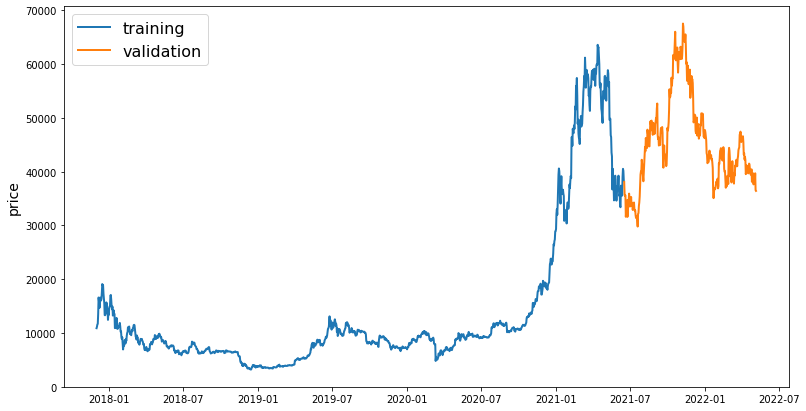

In [11]:
line_plot(train['close'], val['close'], 'training', 'validation', title='')

# Model

## def

In [122]:
class Crypto:
  test_size = 0.2
  zero_base = True
  lstm_neurons = 100
  epochs = 100
  batch_size = 32
  loss = 'binary_crossentropy'
  dropout = 0.2
  optimizer = 'adam'
  def __init__(self, output_size, window, drop_col):
    self.window_len = window
    self.output_size = output_size
    self.eval = []
    self.hist = hist.drop(columns=drop_col, axis=0)


  def extract_window_data(self, df, window_len, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)


  def prepare_data_classification(self, df, target_col, window_len=5, zero_base=True, test_size=0.2):
      train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
      X_train = self.extract_window_data(train_data, window_len, zero_base)
      X_test = self.extract_window_data(test_data, window_len, zero_base)
      y_train = train_data[target_col][window_len:].values#ori
      y_test = test_data[target_col][window_len:].values#ori

      return  X_train, X_test, y_train, y_test


  def build_lstm_model(self, input_data, output_size, neurons=100, activ_func='tanh',
                      dropout=0.2, loss='binary_crossentropy', optimizer='adam'):
      model = Sequential()
      model.add(LSTM(100, input_shape=(input_data.shape[1], input_data.shape[2])))
      model.add(Activation(activ_func))
      model.add(Dropout(dropout))
      # model.add(Dense(50, activation=activ_func))
      model.add(Dense(units=1))
      model.add(Activation('sigmoid'))
      # model.add(Activation('softmax'))
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      return model

  def data_set(self):
      self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data_classification(
          self.hist, target_col, window_len=self.window_len, zero_base=self.zero_base, test_size=self.test_size)
      # train.drop(target_col, axis = 1, inplace=True)


  def train_model(self):
    early_stopping = EarlyStopping(monitor = 'val_loss', patience=20)
    self.model = self.build_lstm_model(
        self.X_train, output_size,neurons=self.lstm_neurons, dropout=self.dropout, loss=self.loss,
        optimizer=self.optimizer)
    self.history = self.model.fit(
        self.X_train, self.y_train, validation_data=(self.X_test, self.y_test), epochs=self.epochs, batch_size = self.batch_size, verbose=1, shuffle=True,
        callbacks=[early_stopping])
    print(self.model.summary())
  
  def evaluate(self):
    self.train_model()
    self.preds = self.model.predict(self.X_test).squeeze()
    self.preds_X = self.model.predict(self.X_train).squeeze()
    scores = self.model.evaluate(self.X_test, self.y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

  def conditions(self):
    return self.hist.columns, 'dropout:',self.dropout, 'window_size:', self.window_len


## TEST

### scaling

In [123]:
price = make_price_features(load_price_data())
price.loc[price['diff']>0, 'direction'] = 1
target_col = 'direction'

In [124]:
hist = total.join(price, how='outer')
hist.dropna(inplace = True)
scaler = MinMaxScaler()
hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low','close',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']] =  scaler.fit_transform(hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low', 'close',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']])
# hist['close'] = scaler1.fit_transform(hist['close'])


In [126]:
#ohlcv + flcut
window_size = 5
output_size = 1
drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 6s 29ms/step - loss: 0.6936 - accuracy: 0.5191 - val_loss: 0.6926 - val_accuracy: 0.5269
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5324 - val_loss: 0.6920 - val_accuracy: 0.5269
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6889 - accuracy: 0.5377 - val_loss: 0.6912 - val_accuracy: 0.5125
Epoch 4/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.5368 - val_loss: 0.6909 - val_accuracy: 0.5161
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.5395 - val_loss: 0.6903 - val_accuracy: 0.5233
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.5315 - val_loss: 0.6897 - val_accuracy: 0.5484
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6886 - accuracy: 0.5386 - val_loss: 0.6894 - val_accuracy: 0.5448
Epoch 8/100


In [128]:
#ohlcv + flcut + pos, mean
window_size = 5
output_size = 1
drop_col = ['neu', 'neg', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 2s 18ms/step - loss: 0.6942 - accuracy: 0.5235 - val_loss: 0.6927 - val_accuracy: 0.4982
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5173 - val_loss: 0.6962 - val_accuracy: 0.5018
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5280 - val_loss: 0.6954 - val_accuracy: 0.5018
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5262 - val_loss: 0.6910 - val_accuracy: 0.5269
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5350 - val_loss: 0.6915 - val_accuracy: 0.5054
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5421 - val_loss: 0.6900 - val_accuracy: 0.5412
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5333 - val_loss: 0.6900 - val_accuracy: 0.5412
Epoch 8/100


In [ ]:
#only close
window_size = 5
output_size = 1
drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 'open', 'high', 'low', 'volume','fluct',
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 3s 17ms/step - loss: 0.6931 - accuracy: 0.5120 - val_loss: 0.6959 - val_accuracy: 0.4839
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5306 - val_loss: 0.6929 - val_accuracy: 0.5018
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5439 - val_loss: 0.6959 - val_accuracy: 0.4803
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.5350 - val_loss: 0.6913 - val_accuracy: 0.5233
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6892 - accuracy: 0.5448 - val_loss: 0.6919 - val_accuracy: 0.5341
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6870 - accuracy: 0.5555 - val_loss: 0.6909 - val_accuracy: 0.5484
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5430 - val_loss: 0.6929 - val_accuracy: 0.5269
Epoch 8/100


In [ ]:
#only fluct
window_size = 5
output_size = 1
drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 'open', 'high', 'low', 'volume','close',
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 3s 18ms/step - loss: 0.6927 - accuracy: 0.5413 - val_loss: 0.6962 - val_accuracy: 0.5018
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.5350 - val_loss: 0.6944 - val_accuracy: 0.5018
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5342 - val_loss: 0.6952 - val_accuracy: 0.5018
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5226 - val_loss: 0.6935 - val_accuracy: 0.5018
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5368 - val_loss: 0.6936 - val_accuracy: 0.5018
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5377 - val_loss: 0.6949 - val_accuracy: 0.5018
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5404 - val_loss: 0.6928 - val_accuracy: 0.4982
Epoch 8/100


In [ ]:
crypto_obj.preds

array([0.57605815, 0.48254308, 0.5431227 , 0.6099509 , 0.5572883 ,
       0.4089834 , 0.4221502 , 0.6162906 , 0.5276903 , 0.4468785 ,
       0.5947346 , 0.6391342 , 0.41675377, 0.52437   , 0.6567447 ,
       0.45770678, 0.5784855 , 0.5254231 , 0.55041164, 0.49256468,
       0.4443389 , 0.5992581 , 0.63402563, 0.5338245 , 0.516515  ,
       0.5359253 , 0.41905484, 0.5635757 , 0.5862143 , 0.48733878,
       0.50311935, 0.61230874, 0.514679  , 0.4738924 , 0.6043759 ,
       0.52455217, 0.5708914 , 0.60045695, 0.42266345, 0.4187851 ,
       0.51739204, 0.6172131 , 0.51067036, 0.55224556, 0.59729093,
       0.42776743, 0.53159916, 0.52281296, 0.5409005 , 0.59382606,
       0.42757294, 0.53573   , 0.63681334, 0.42652062, 0.4235685 ,
       0.6126448 , 0.6349017 , 0.44402495, 0.44216457, 0.52058566,
       0.52210915, 0.512288  , 0.53715235, 0.5366269 , 0.5226754 ,
       0.6015451 , 0.4975787 , 0.532375  , 0.58322036, 0.521263  ,
       0.49133456, 0.4087413 , 0.41723606, 0.5408912 , 0.53625

In [ ]:
crypto_obj.preds

array([0.50786495, 0.5213136 , 0.52731735, 0.62939125, 0.5197164 ,
       0.52537817, 0.5309714 , 0.530686  , 0.52488506, 0.53548247,
       0.5418254 , 0.63009757, 0.5373725 , 0.54864365, 0.5559663 ,
       0.562014  , 0.636654  , 0.63266253, 0.6374603 , 0.6304545 ,
       0.54065084, 0.5508999 , 0.6383052 , 0.6272486 , 0.6152356 ,
       0.5223359 , 0.61282754, 0.6149377 , 0.61195135, 0.5399182 ,
       0.54231024, 0.6248226 , 0.53279877, 0.5361864 , 0.62061375,
       0.5307426 , 0.5379788 , 0.6222321 , 0.5470311 , 0.6260559 ,
       0.5502111 , 0.62794816, 0.6283898 , 0.5434118 , 0.61961955,
       0.54941773, 0.55225086, 0.62910753, 0.5603166 , 0.631697  ,
       0.5620973 , 0.6340228 , 0.6464485 , 0.5620124 , 0.62606096,
       0.6352716 , 0.6253182 , 0.61849964, 0.54059   , 0.62197715,
       0.5499422 , 0.62557256, 0.55121815, 0.5430404 , 0.54760736,
       0.5518357 , 0.55654144, 0.5616188 , 0.5660864 , 0.63689315,
       0.5733183 , 0.6321343 , 0.6415162 , 0.5626048 , 0.55788

In [ ]:
#ohlcv + flcut
window_size = 5
output_size = 1
drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 2s 17ms/step - loss: 0.6938 - accuracy: 0.5235 - val_loss: 0.6936 - val_accuracy: 0.4946
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5395 - val_loss: 0.6928 - val_accuracy: 0.5054
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5262 - val_loss: 0.6914 - val_accuracy: 0.5233
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5297 - val_loss: 0.6912 - val_accuracy: 0.5197
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5368 - val_loss: 0.6909 - val_accuracy: 0.5233
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.5413 - val_loss: 0.6900 - val_accuracy: 0.5412
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5377 - val_loss: 0.6902 - val_accuracy: 0.5341
Epoch 8/100


In [ ]:
#ohlcv + flcut
window_size = 14
output_size = 1
drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
35/35 [==============================] - 3s 18ms/step - loss: 0.6904 - accuracy: 0.5429 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.5188 - val_loss: 0.6907 - val_accuracy: 0.5222
Epoch 3/100
35/35 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5340 - val_loss: 0.6902 - val_accuracy: 0.5333
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5268 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5376 - val_loss: 0.6896 - val_accuracy: 0.5556
Epoch 6/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6894 - accuracy: 0.5340 - val_loss: 0.6893 - val_accuracy: 0.5259
Epoch 7/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6888 - accuracy: 0.5420 - val_loss: 0.6891 - val_accuracy: 0.5370
Epoch 8/100


In [ ]:
crypto_obj.preds

array([0.54384375, 0.44270718, 0.49812296, 0.52669406, 0.52216065,
       0.54719025, 0.68064755, 0.62192476, 0.5571311 , 0.6413974 ,
       0.55858   , 0.6038569 , 0.6193905 , 0.4868984 , 0.4339529 ,
       0.46048453, 0.6078874 , 0.5501373 , 0.607955  , 0.6275935 ,
       0.48648056, 0.53005034, 0.47324637, 0.55541545, 0.60451514,
       0.49752122, 0.5520624 , 0.59988034, 0.49534932, 0.45927992,
       0.58599645, 0.64417887, 0.5234549 , 0.47575983, 0.49798292,
       0.52316827, 0.5302024 , 0.5572402 , 0.534981  , 0.52722925,
       0.6206888 , 0.5000381 , 0.5636285 , 0.5855931 , 0.5600453 ,
       0.5209042 , 0.40961993, 0.36782616, 0.41205677, 0.50101715,
       0.6645242 , 0.6040707 , 0.6248238 , 0.62043643, 0.57223856,
       0.42652053, 0.43135312, 0.4882407 , 0.52411795, 0.5370937 ,
       0.45210835, 0.42030296, 0.47630784, 0.6421896 , 0.59048015,
       0.52638704, 0.61103475, 0.5246234 , 0.5514555 , 0.46591553,
       0.49340945, 0.527127  , 0.51911914, 0.4118973 , 0.36491

In [ ]:
#ohlcv + flcut
window_size = 30
output_size = 1
drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
35/35 [==============================] - 4s 22ms/step - loss: 0.6946 - accuracy: 0.5272 - val_loss: 0.6915 - val_accuracy: 0.5276
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5354 - val_loss: 0.6944 - val_accuracy: 0.4882
Epoch 3/100
35/35 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5281 - val_loss: 0.6900 - val_accuracy: 0.5394
Epoch 4/100
35/35 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5290 - val_loss: 0.6898 - val_accuracy: 0.5512
Epoch 5/100
35/35 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5272 - val_loss: 0.6892 - val_accuracy: 0.5866
Epoch 6/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6881 - accuracy: 0.5426 - val_loss: 0.6890 - val_accuracy: 0.5236
Epoch 7/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6877 - accuracy: 0.5490 - val_loss: 0.6941 - val_accuracy: 0.4961
Epoch 8/100


In [ ]:
#ohlcv + flcut + pos
window_size = 5
output_size = 1
drop_col = ['neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 3s 17ms/step - loss: 0.6958 - accuracy: 0.5244 - val_loss: 0.6929 - val_accuracy: 0.4982
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5342 - val_loss: 0.6919 - val_accuracy: 0.5018
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5324 - val_loss: 0.6908 - val_accuracy: 0.5341
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5164 - val_loss: 0.6944 - val_accuracy: 0.5018
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5350 - val_loss: 0.6901 - val_accuracy: 0.5484
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5324 - val_loss: 0.6899 - val_accuracy: 0.5305
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5430 - val_loss: 0.6899 - val_accuracy: 0.5341
Epoch 8/100


In [ ]:
#ohlcv + flcut + pos, neu, neg, mean, var
window_size = 5
output_size = 1
drop_col = [ 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 2s 17ms/step - loss: 0.6936 - accuracy: 0.5315 - val_loss: 0.6925 - val_accuracy: 0.5448
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5368 - val_loss: 0.6915 - val_accuracy: 0.5305
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5386 - val_loss: 0.6924 - val_accuracy: 0.5090
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5324 - val_loss: 0.6932 - val_accuracy: 0.5018
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5368 - val_loss: 0.6926 - val_accuracy: 0.5090
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5350 - val_loss: 0.6896 - val_accuracy: 0.5556
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6875 - accuracy: 0.5421 - val_loss: 0.6893 - val_accuracy: 0.5699
Epoch 8/100


In [ ]:
crypto_obj.preds

array([0.55944693, 0.43738487, 0.54235655, 0.559874  , 0.5620157 ,
       0.43147334, 0.4677211 , 0.6156372 , 0.49283868, 0.43303114,
       0.5408385 , 0.5634423 , 0.4165429 , 0.5389171 , 0.6034742 ,
       0.48611397, 0.5982194 , 0.50661266, 0.56391734, 0.4572878 ,
       0.44459182, 0.57980555, 0.5989244 , 0.5427324 , 0.5464541 ,
       0.5534336 , 0.43506932, 0.5591911 , 0.49938112, 0.47938618,
       0.47686312, 0.6065213 , 0.4698202 , 0.45328784, 0.6013214 ,
       0.49241802, 0.5533209 , 0.5869168 , 0.46701238, 0.44953677,
       0.50034887, 0.60774726, 0.47475448, 0.5526587 , 0.563807  ,
       0.43683973, 0.54959023, 0.49437264, 0.5804218 , 0.5959333 ,
       0.44805077, 0.53187776, 0.5821368 , 0.4562134 , 0.45329264,
       0.6125766 , 0.59972274, 0.44522265, 0.46471164, 0.5055311 ,
       0.4982664 , 0.47835514, 0.4935861 , 0.49403852, 0.48207375,
       0.60412043, 0.48159042, 0.5522251 , 0.57373506, 0.56847525,
       0.56069624, 0.46516052, 0.45192897, 0.4855764 , 0.49328

In [ ]:
#ohlcv + flcut + pos, neu, neg, mean, var
window_size = 5
output_size = 1
# drop_col = [ 'EMA_short', 'EMA_long', 'MACD',
#       'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
#       'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
#       'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
#       'estrangementRatio25', 'estrangementRatio99',
#       'estrangementRatio25_volume', 'diff']

crypto_obj = Crypto(output_size, window_size, drop_col)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/100
36/36 [==============================] - 3s 17ms/step - loss: 0.6921 - accuracy: 0.5324 - val_loss: 0.6940 - val_accuracy: 0.4982
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5209 - val_loss: 0.6915 - val_accuracy: 0.5197
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5386 - val_loss: 0.6903 - val_accuracy: 0.5412
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5404 - val_loss: 0.6904 - val_accuracy: 0.5197
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5368 - val_loss: 0.6894 - val_accuracy: 0.5197
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5377 - val_loss: 0.6904 - val_accuracy: 0.5233
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5510 - val_loss: 0.6894 - val_accuracy: 0.5520
Epoch 8/100


In [ ]:
crypto_obj.y_tests

[array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1])]

In [ ]:
temp = crypto_obj.preds
for i in range(len(temp)):
  if temp[i]>=0.5:
    temp[i] = 1
  else:
    temp[i] = 0

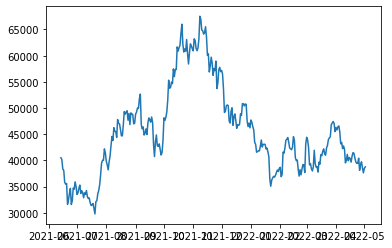

In [ ]:
plt.plot(val.close)


In [ ]:
crypto_obj.preds

array([0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581094,
       0.54581094, 0.54581094, 0.54581094, 0.54581094, 0.54581

In [ ]:
crypto_obj.model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               42800     
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
 activation_9 (Activation)   (None, 1)                

In [ ]:
crypto_obj.X_tests[0]

array([[[4.05253900e+04, 4.22000000e+04, 3.34880000e+04, 3.72520100e+04,
         2.02100888e+05, 0.00000000e+00],
        [3.72633500e+04, 3.88290000e+04, 3.52006200e+04, 3.74497300e+04,
         1.26542244e+05, 1.00000000e+00],
        [3.74585100e+04, 3.82706400e+04, 3.11110100e+04, 3.46552500e+04,
         2.17136047e+05, 0.00000000e+00],
        ...,
        [3.72538200e+04, 3.78948100e+04, 3.56660000e+04, 3.66930900e+04,
         8.12346638e+04, 0.00000000e+00],
        [3.66948500e+04, 3.82250000e+04, 3.59200000e+04, 3.75686800e+04,
         6.75873725e+04, 1.00000000e+00],
        [3.75686800e+04, 3.94760000e+04, 3.71700000e+04, 3.92467900e+04,
         7.58891060e+04, 1.00000000e+00]],

       [[3.72633500e+04, 3.88290000e+04, 3.52006200e+04, 3.74497300e+04,
         1.26542244e+05, 1.00000000e+00],
        [3.74585100e+04, 3.82706400e+04, 3.11110100e+04, 3.46552500e+04,
         2.17136047e+05, 0.00000000e+00],
        [3.46814400e+04, 3.99200000e+04, 3.40310000e+04, 3.879629

In [ ]:
crypto_obj.model.predict(x)

array([[0.4810003]], dtype=float32)

In [ ]:
x = np.arange(14*6).reshape(1,14,6)
x

array([[[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47],
        [48, 49, 50, 51, 52, 53],
        [54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65],
        [66, 67, 68, 69, 70, 71],
        [72, 73, 74, 75, 76, 77],
        [78, 79, 80, 81, 82, 83]]])

In [ ]:
crypto_obj.X_trains[0].shape

(1118, 14, 6)

In [ ]:
crypto_obj.X_trains[0]

array([[[1.22481521e-01, 1.27404962e-01, 1.21878872e-01, 1.14910000e+04,
         4.32744962e-02, 1.00000000e+00],
        [1.34779755e-01, 1.32350225e-01, 1.26585994e-01, 1.12510000e+04,
         3.15684235e-02, 0.00000000e+00],
        [1.24986570e-01, 1.22207734e-01, 1.06931231e-01, 1.02375100e+04,
         5.99801024e-02, 0.00000000e+00],
        ...,
        [6.82166013e-02, 6.94956903e-02, 7.00190308e-02, 7.78402000e+03,
         0.00000000e+00, 1.00000000e+00],
        [7.11848458e-02, 8.30981308e-02, 7.34727066e-02, 8.68392000e+03,
         4.73229686e-02, 1.00000000e+00],
        [8.50858389e-02, 8.80853880e-02, 7.87068941e-02, 8.53398000e+03,
         1.19446838e-01, 0.00000000e+00]],

       [[1.34779755e-01, 1.32350225e-01, 1.26585994e-01, 1.12510000e+04,
         3.15684235e-02, 0.00000000e+00],
        [1.24986570e-01, 1.22207734e-01, 1.06931231e-01, 1.02375100e+04,
         5.99801024e-02, 0.00000000e+00],
        [1.09125198e-01, 1.08779204e-01, 1.03759957e-01, 1.028510

In [ ]:
crypto_obj.model.predict(crypto_obj.X_trains[0])

array([[0.5639076],
       [0.5639076],
       [0.5639076],
       ...,
       [0.5639076],
       [0.5639076],
       [0.5639076]], dtype=float32)

In [ ]:
crypto_obj.model.predict(crypto_obj.X_tests[0])

array([[0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.5639076 ],
       [0.563

### close

Epoch 1/20
36/36 [==============================] - 4s 23ms/step - loss: 0.6440 - accuracy: 0.1695 - val_loss: 0.4879 - val_accuracy: 0.0000e+00
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.4720 - accuracy: 0.0027 - val_loss: 0.3301 - val_accuracy: 0.0000e+00
Epoch 3/20
36/36 [==============================] - 0s 7ms/step - loss: 0.3703 - accuracy: 8.8731e-04 - val_loss: 0.2410 - val_accuracy: 0.0000e+00
Epoch 4/20
36/36 [==============================] - 0s 8ms/step - loss: 0.3197 - accuracy: 0.0000e+00 - val_loss: 0.1871 - val_accuracy: 0.0000e+00
Epoch 5/20
36/36 [==============================] - 0s 7ms/step - loss: 0.2904 - accuracy: 0.0000e+00 - val_loss: 0.1624 - val_accuracy: 0.0000e+00
Epoch 6/20
36/36 [==============================] - 0s 7ms/step - loss: 0.2766 - accuracy: 0.0000e+00 - val_loss: 0.1368 - val_accuracy: 0.0000e+00
Epoch 7/20
36/36 [==============================] - 0s 7ms/step - loss: 0.2705 - accuracy: 0.0000e+00 - val_loss: 0.122

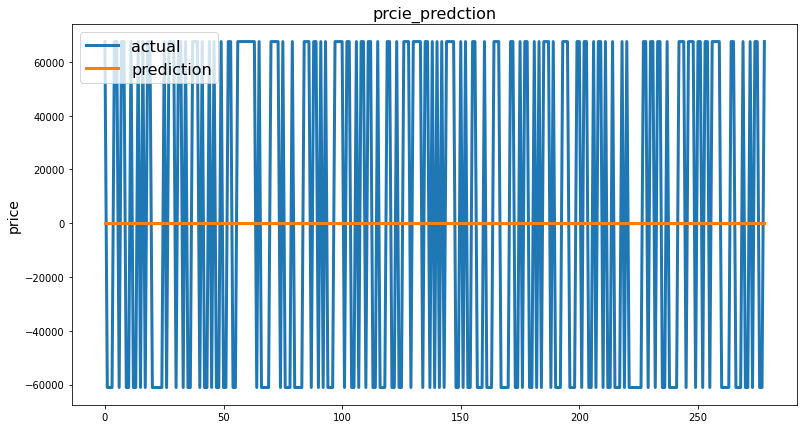

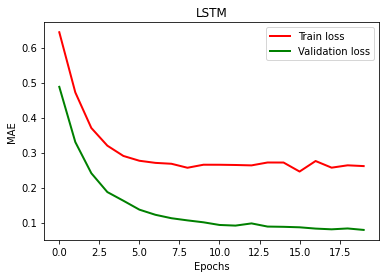

(Index(['open', 'high', 'low', 'close', 'volume', 'direction'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)


In [ ]:
#close

window_size = 5
split = 1
output_size = 1
drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']

execute(split, output_size, drop_col, window_size)

### ohlcv + fluct

Epoch 1/100
36/36 [==============================] - 6s 34ms/step - loss: 0.0137 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 8.7414e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.7203e-04 - val_loss: 0.0015
Epoch 9/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 7.1104e-04 - val_loss: 0.0

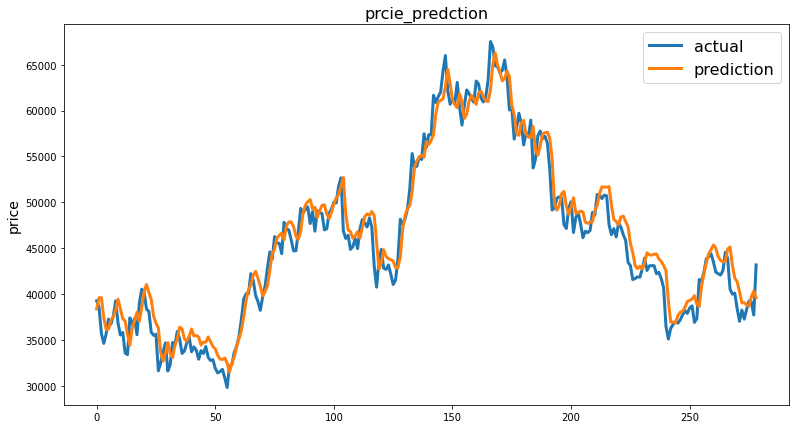

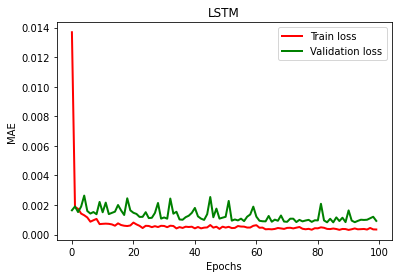

MAE:[0.023798147241650316] RMSE:[0.0304679306666478] R2:[0.9542063709479429]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0125 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.9421e-04 - val_loss: 0.0014
Epoch 9/100
3

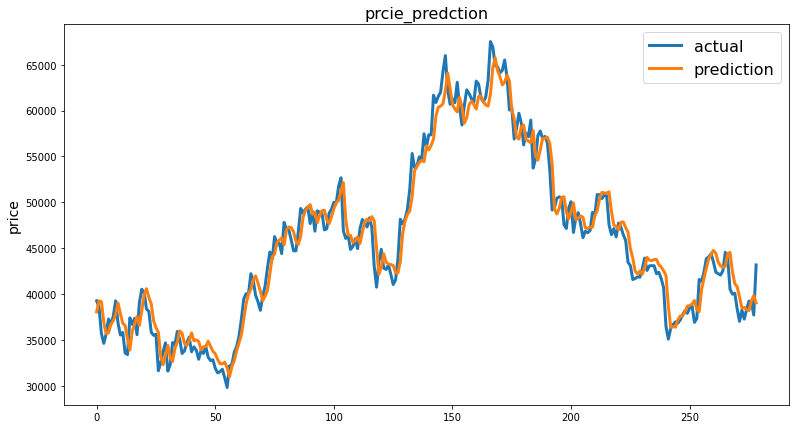

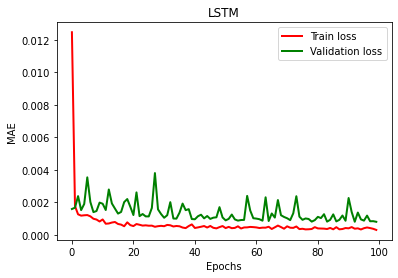

MAE:[0.021778180182889774] RMSE:[0.02841609395294301] R2:[0.9601665516449607]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 31ms/step - loss: 0.0107 - val_loss: 0.0037
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 9.4151e-04 - val_loss: 0.0018
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 8.4314e-04 - val_loss: 0.0014
Epoch 9/

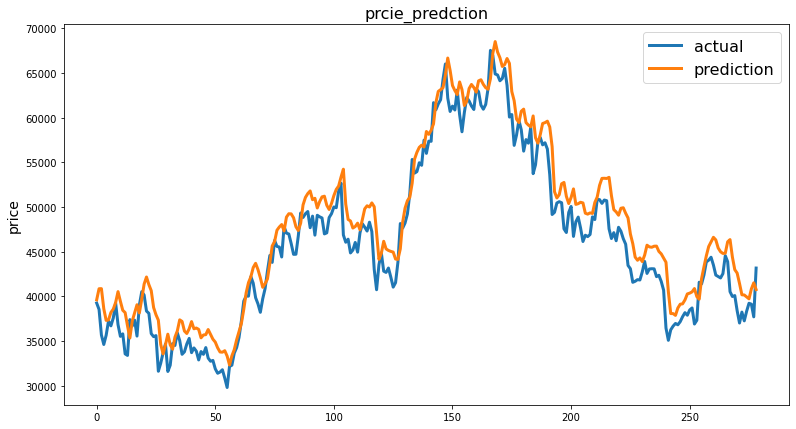

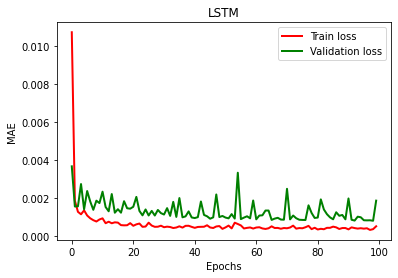

MAE:[0.036146038955720154] RMSE:[0.04325087273139221] R2:[0.9077197218169069]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 9.3178e-04 - val_loss: 0.0014
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 8.5776e-04 - val_loss: 0.0017
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 8.5335e-04 - val_loss: 0.0014
Epoc

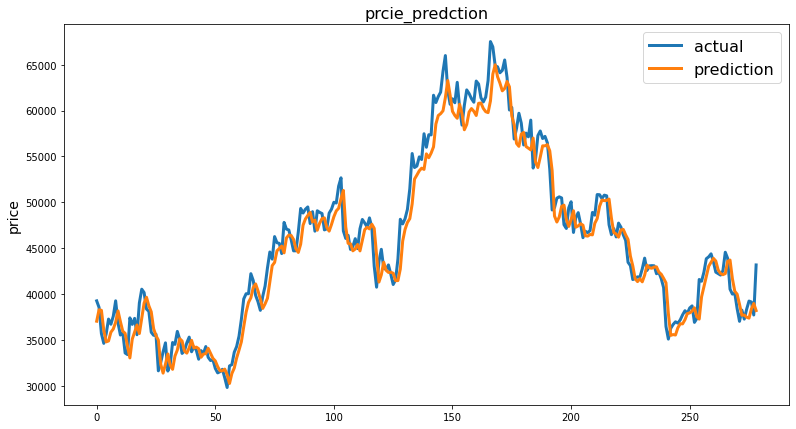

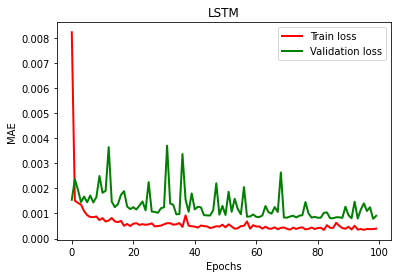

MAE:[0.023718354095840933] RMSE:[0.03011695867530914] R2:[0.9552553236918774]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0093 - val_loss: 0.0020
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 9.0191e-04 - val_loss: 0.0019
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 9.0261e-04 - val_loss: 0.0013
Epoch 9/

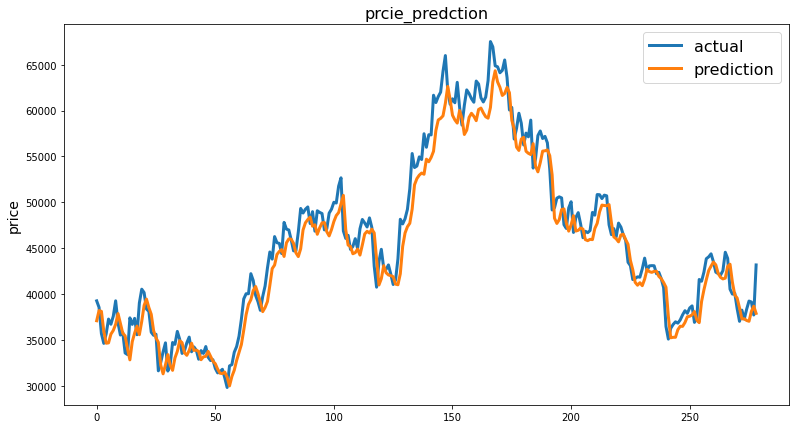

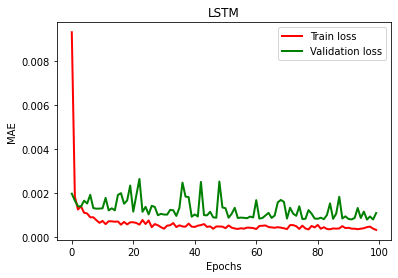

MAE:[0.026398638855898847] RMSE:[0.03308160844715564] R2:[0.9460126042203854]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Minimal RMSE:0.02841609395294301


In [ ]:
#ohlcv + fluct
rmse = 100
for i in range(5):
  
  window_size = 5
  split = 1
  output_size = 1
  drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
        'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25',
        'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
        'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
        'estrangementRatio25', 'estrangementRatio99',
        'estrangementRatio25_volume']

  rmse = min(execute(split, output_size, drop_col, window_size),rmse)
print(f'Minimal RMSE:{rmse}')

### Total:ohlcv + fluct + pos

Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0107 - val_loss: 0.0035
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 9.1057e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 9/100
36/36 [==============================] - 0s 6ms/step - loss: 7.2387e-04 - val_loss: 0.0014
Epoch 10/100
36/36 [==============================] - 0s 6ms/step - loss: 9.3842e-04 - val_loss: 0.0

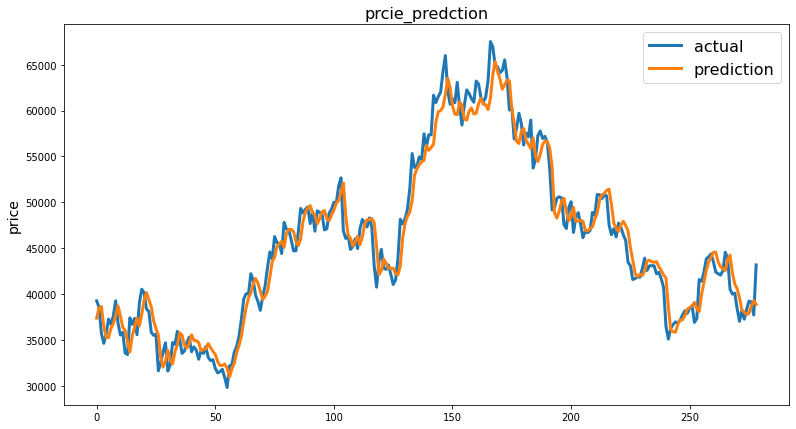

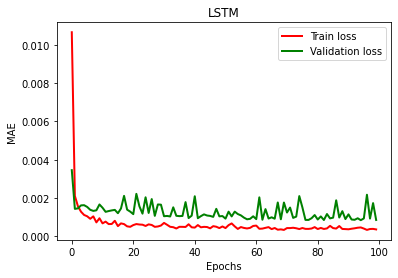

MAE:[0.022676921861605397] RMSE:[0.029155458708552365] R2:[0.9580667134484786]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0133 - val_loss: 0.0024
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 9.5297e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0017
Epoc

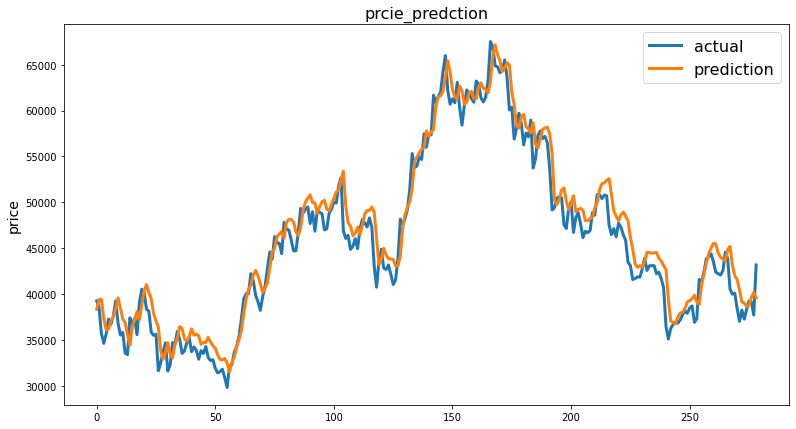

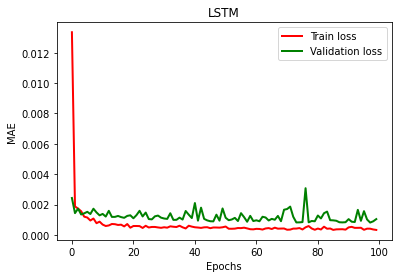

MAE:[0.02536860264728676] RMSE:[0.03232743471748672] R2:[0.9484460873574427]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 7s 37ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 9.4279e-04 - val_loss: 0.0013
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 8.1166e-04 - val_loss: 0.0026
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 8.0932e-04 - val_loss: 0.0

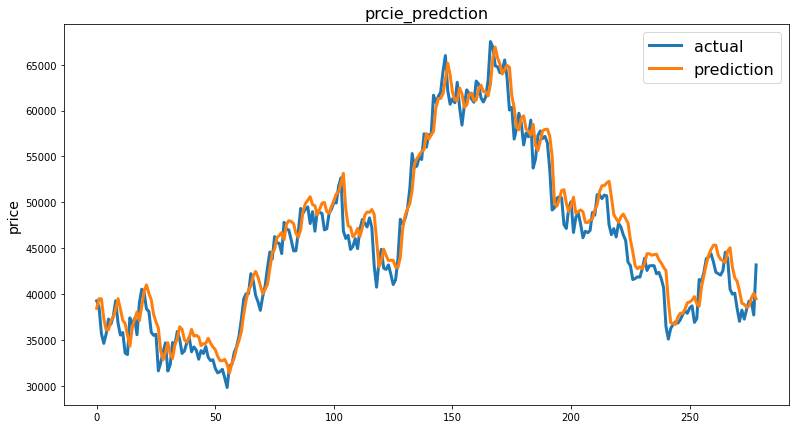

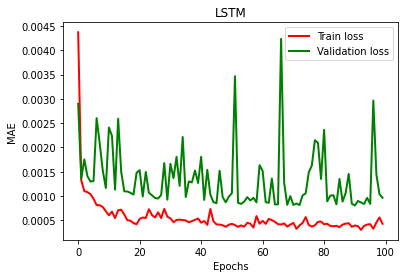

MAE:[0.024156814431696778] RMSE:[0.031036895197000917] R2:[0.9524800818381086]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 7.6741e-04 - val_loss: 0.0013
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 8.4844e-04 - val_loss: 0.0013


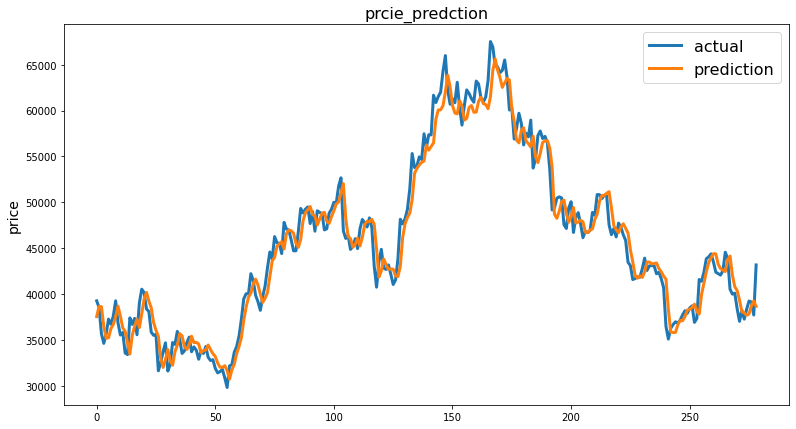

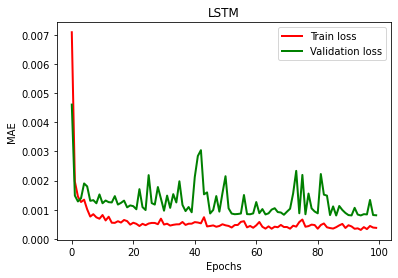

MAE:[0.022058598241148933] RMSE:[0.028485237172962998] R2:[0.9599724670025799]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0150 - val_loss: 0.0020
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 9.8788e-04 - val_loss: 0.0014
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 8.0899e-04 - val_loss: 0.0023
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.1020e-04 - val_loss: 0.0

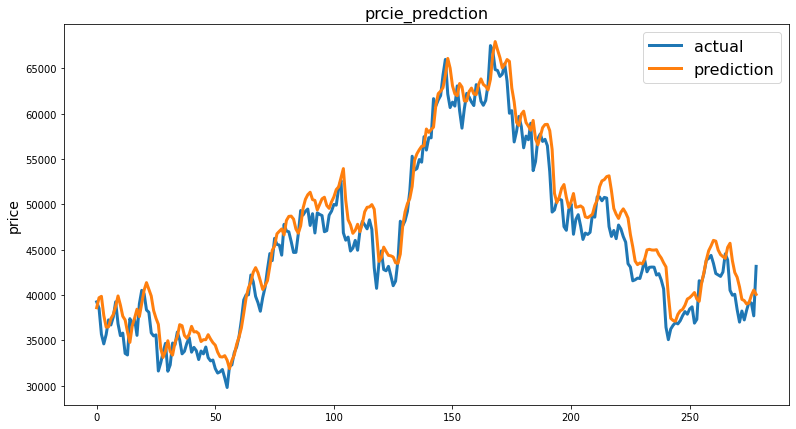

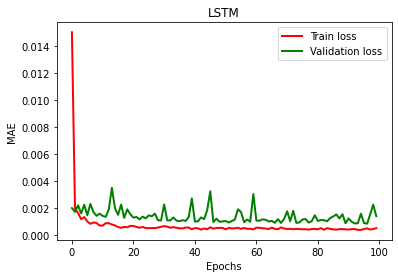

MAE:[0.029819756828883423] RMSE:[0.03713486443795186] R2:[0.931972763266776]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Minimal RMSE:0.028485237172962998


In [ ]:
#Total: ohlcv + fluct + pos
rmse = 100
for i in range(5):
  
  window_size = 5
  split = 1
  output_size = 1
  drop_col = ['neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
        'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25',
        'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
        'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
        'estrangementRatio25', 'estrangementRatio99',
        'estrangementRatio25_volume']

  rmse = min(execute(split, output_size, drop_col, window_size),rmse)
print(f'Minimal RMSE:{rmse}')

### crypto: ohlcv + fluct + pos

In [ ]:
hist = crypto_day.join(price, how='outer')
hist.dropna(inplace = True)
scaler = MinMaxScaler()
hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']] =  scaler.fit_transform(hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff']])
scaler1 = MinMaxScaler()
# hist['close'] = scaler1.fit_transform(hist['close'])
hist['close'] = scaler1.fit_transform(hist['close'].values.reshape(-1,1))


Epoch 1/100
36/36 [==============================] - 3s 32ms/step - loss: 0.0138 - val_loss: 0.0015
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.0270e-04 - val_loss: 0.0019
Epoch 9/100
36/36 [==============================] - 0s 6ms/step - loss: 8.6547e-04 - val_loss: 0.0013
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 8.0747e-04 - val_loss: 0.0

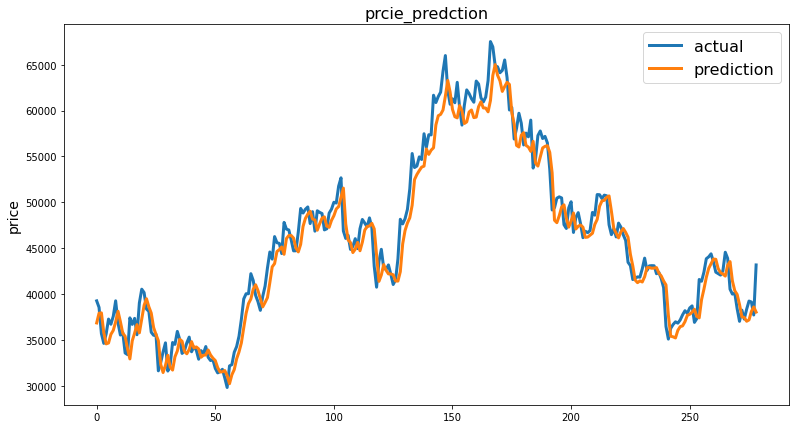

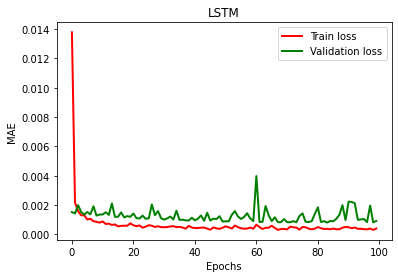

MAE:[0.024074473302616313] RMSE:[0.030354348508595905] R2:[0.9545471649564711]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 9.7284e-04 - val_loss: 0.0013
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 8.3247e-04 - val_loss: 0.0018
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 8.6350e-04 - val_loss: 0.0013
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 7.9076e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 7.8648e-04 - val_l

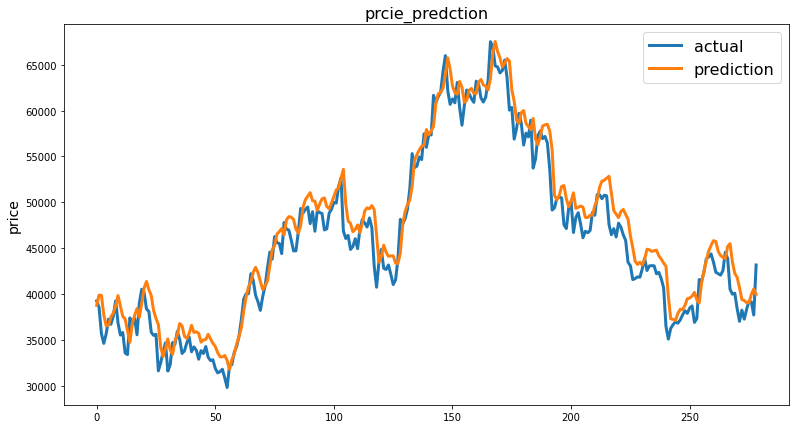

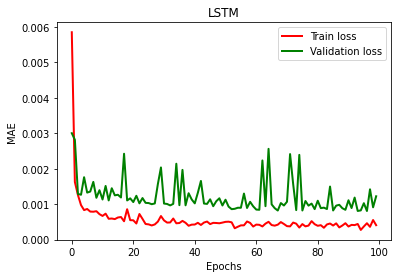

MAE:[0.027807357603337225] RMSE:[0.034954975285002056] R2:[0.9397250105033785]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0139 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 8.0507e-04 - val_loss: 0.0013
Epoc

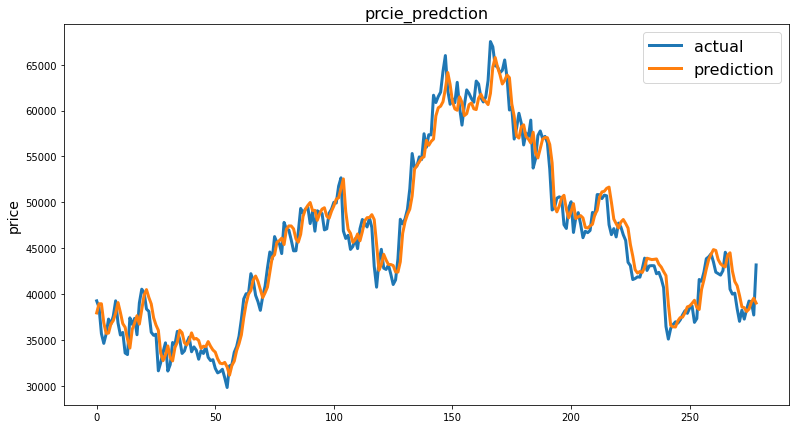

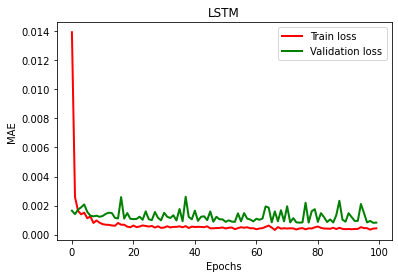

MAE:[0.021976767304810452] RMSE:[0.028745642118655646] R2:[0.9592372783567374]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 9.0565e-04 - val_loss: 0.0013
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 7.4544e-04 - val_loss: 0.0014


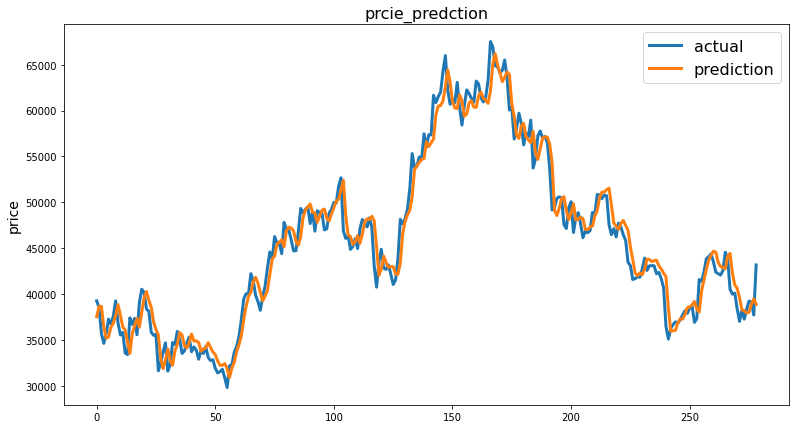

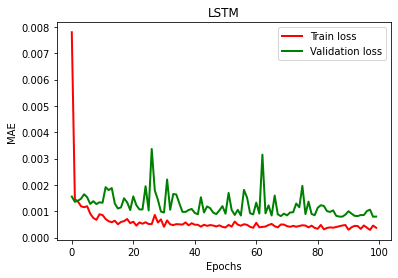

MAE:[0.021634817765383355] RMSE:[0.028224391332083022] R2:[0.9607021930747064]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0173 - val_loss: 0.0025
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 9/

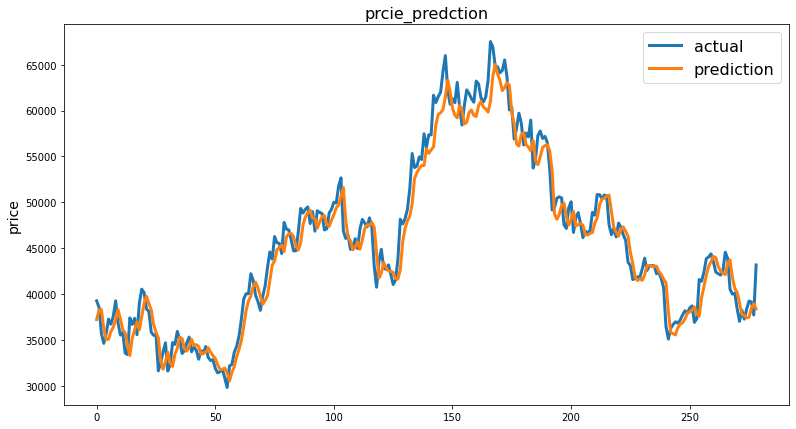

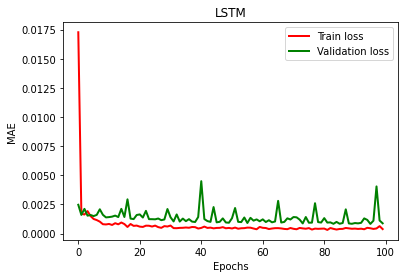

MAE:[0.023282565425218785] RMSE:[0.029615267489852] R2:[0.9567336296118663]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Minimal RMSE:0.028224391332083022


In [ ]:
#Crypto: ohlcv + fluct + pos
rmse = 100
for i in range(5):
  
  window_size = 5
  split = 1
  output_size = 1
  drop_col = ['neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
        'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25',
        'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
        'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
        'estrangementRatio25', 'estrangementRatio99',
        'estrangementRatio25_volume']

  rmse = min(execute(split, output_size, drop_col, window_size),rmse)
print(f'Minimal RMSE:{rmse}')

sentiment 모델 성능 향상 비교(minimal RMSE)

In [ ]:
(0.02841609395294301 - 0.028224391332083022)/0.028224391332083022 *100

0.6792090522146215